How does `WARC-Identified-Content-Language` (cld2) differ from fasttext `lid.176.bin`?

```bash
# Download 1 shard and extract WARC-Identified-Content-Language into "languages" field
python -m cc_net.process_wet_file dl --dump 2023-50 --num_shards 2000 --shard 0 --output data/raw/2023-50/0000.jsonl

# Run fasttext and get top 10 highest probability languages
python -m cc_net.split_by_lang -f data/raw/2023-50/0000.jsonl --model bin/lid.bin --field raw_content --out_field fasttext_languages --top 10 --output data/lang_exp/top_10.json
```

In [7]:
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [15]:
# For each of the nordic languages, plot precision/recall curve, i.e. how well does FT align with cld2 labels?
cld2_labels = []
fasttext_scores = []
texts = []

with open("../data/lang_exp/top_10.json") as f:
    for line in tqdm(f):
        parsed = json.loads(line)
        texts.append(parsed["raw_content"])
        cld2_labels.append(set(parsed["languages"]))
        fasttext_scores.append(parsed["fasttext_languages"])

1563389it [01:51, 14057.07it/s]


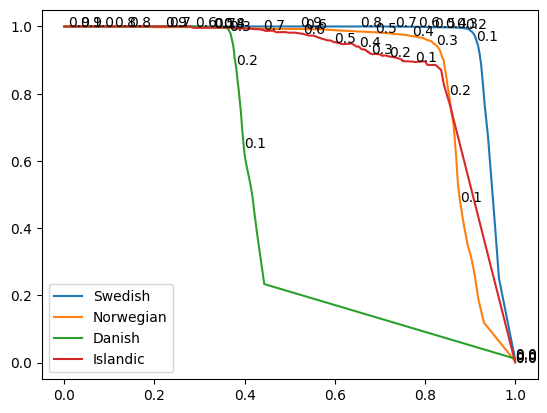

In [14]:
sv_precision, sv_recall, sv_thresholds = precision_recall_curve(
    y_true=[1 if "swe" in cld2_labels[i] else 0 for i in range(len(cld2_labels))],
    probas_pred=[fasttext_scores[i].get("sv", 0.0) for i in range(len(cld2_labels))]
)

da_precision, da_recall, da_thresholds = precision_recall_curve(
    y_true=[1 if "dan" in cld2_labels[i] else 0 for i in range(len(cld2_labels))],
    probas_pred=[fasttext_scores[i].get("da", 0.0) for i in range(len(cld2_labels))]
)

is_precision, is_recall, is_thresholds = precision_recall_curve(
    y_true=[1 if "isl" in cld2_labels[i] else 0 for i in range(len(cld2_labels))],
    probas_pred=[fasttext_scores[i].get("is", 0.0) for i in range(len(cld2_labels))]
)

no_precision, no_recall, no_thresholds = precision_recall_curve(
    y_true=[1 if "nor" in cld2_labels[i] else 0 for i in range(len(cld2_labels))],
    probas_pred=[fasttext_scores[i].get("no", 0.0) for i in range(len(cld2_labels))]
)

plt.plot(sv_recall, sv_precision, label="Swedish")
plt.plot(no_recall, no_precision, label="Norwegian")
plt.plot(da_recall, da_precision, label="Danish")
plt.plot(is_recall, is_precision, label="Islandic")

for p, r, t in zip(sv_precision[::10], sv_recall[::10], sv_thresholds[::10]):
    plt.annotate(f"{t:0.1f}", (r, p))

for p, r, t in zip(no_precision[::10], no_recall[::10], no_thresholds[::10]):
    plt.annotate(f"{t:0.1f}", (r, p))

for p, r, t in zip(da_precision[::10], da_recall[::10], da_thresholds[::10]):
    plt.annotate(f"{t:0.1f}", (r, p))

for p, r, t in zip(is_precision[::10], is_recall[::10], is_thresholds[::10]):
    plt.annotate(f"{t:0.1f}", (r, p))

plt.legend()

Danish looks interesting, maybe the cld2 performance of danish is bad? Let's look at FN at t=0.2 

In [20]:
i = 0

In [61]:
while i < len(cld2_labels):
    if "dan" in cld2_labels[i] and fasttext_scores[i].get("da", 0.0) < 0.2:
        print(i, cld2_labels[i], fasttext_scores[i].get("da", 0.0), fasttext_scores[i])
        print(texts[i])
        i += 1
        break
    else:
        i += 1

2810 {'zho', 'dan'} 0.0 {'zh': 0.9, 'ja': 0.06, 'en': 0.01, 'ko': 0.0, 'el': 0.0, 'fr': 0.0, 'ta': 0.0, 'sr': 0.0, 'kn': 0.0, 'ml': 0.0}

首頁
關于我們
產品展示
新聞中心
聯系我們
專業線束制造
支持定制各種規格電子線 、端子線 、排線 、連接線 、線材周邊等
PRODUCT SHOW
產品中心
產品分類
全部分類

{{else}} {{= name}} {{/if}} {{if parent}} {{else}} {{/if}}


線束
上一個
無
下一個
線束
推薦產品
線束

線束

線束

關于我們
公司介紹
企業文化
榮譽資質
設備展示
新聞中心
新聞公告
行業新聞
產品展示
線束加工
塑料緊固件
電子連接器
線束：13701549716
線束郵箱：tonyzhou@c-linket.com
工業零部件：13915415592
工業零部件郵箱：kenyu@c-linket.com
蘇ICP備13011107號-2 網站建設:中企動力 蘇州 2020 ? 蘇州市中連電子科技有限公司 版權所有
国产日韩精品一区二区三区在线观看_爱高潮www亚洲精品_日韩黄色视频_国产裸体美女永久免费无遮挡软件


Seems like mostly not danish, so CLD2 seems quite bad i danish then. How much would we remove if we use fasttext?

Text(0.5, 1.0, 'CLD2 lang distribution')

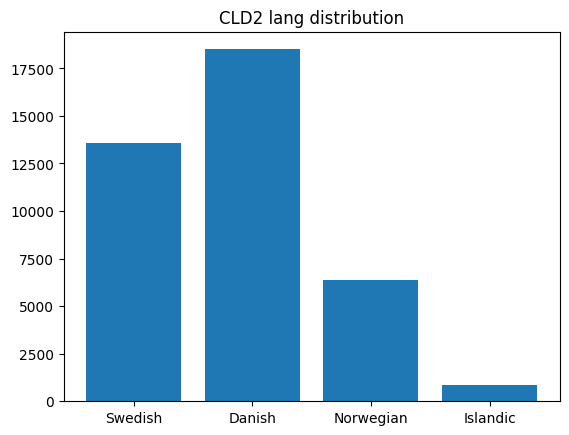

In [39]:
plt.bar(
    ["Swedish", "Danish", "Norwegian", "Islandic"],
    [sum(1 if lang in cld2_labels[i] else 0 for i in range(len(cld2_labels)))
      for lang in ["swe", "dan", "nor", "isl"]]
)
plt.title("CLD2 lang distribution")

Text(0.5, 1.0, 'FastText lang distribution')

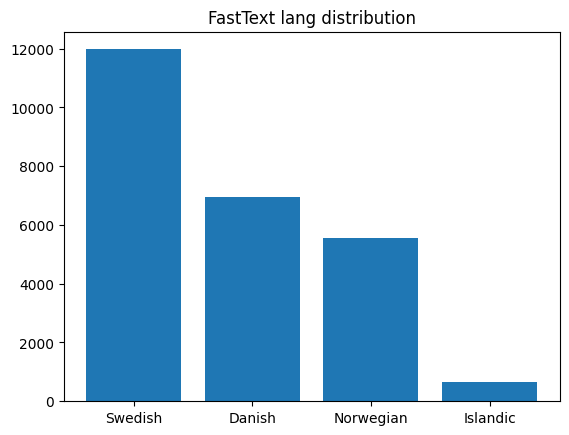

In [54]:
plt.bar(
    ["Swedish", "Danish", "Norwegian", "Islandic"],
    [sum(1 
         if fasttext_scores[i].get(lang, 0.0) > thres and \
          fasttext_scores[i][lang] == max(s for _, s in fasttext_scores[i].items()) 
         else 0 
         for i in range(len(cld2_labels)))
      for lang, thres in [("sv", 0.2), ("da", 0.2), ("no", 0.2), ("is", 0.2)]]
)
plt.title("FastText lang distribution")

In [49]:
# Sample 20 random examples from each language
def print_examples(lang, thres, n=20):
    i = 0
    j = 0
    while j < n:
        if fasttext_scores[i].get(lang, 0.0) > thres and \
            fasttext_scores[i][lang] == max(s for _, s in fasttext_scores[i].items()):
            
            print(fasttext_scores[i][lang])
            print(texts[i])
            print()
            j += 1
        i += 1

In [50]:
print_examples("sv", 0.2)

0.39
juli 04, 2011
Monday
Ägg och bacon, hallon/banansmoothie
Egg and bacon, raspberry/banana smoothie
Santogold - Lights Out
Upplagd av aswedishgal kl. 10:15
Skicka med e-postBlogThis!Dela på TwitterDela på FacebookDela på Pinterest
3 kommentarer:
Ivy sa...
You should open your own Breakfast-Diner. I would be your everyday-guest, even If I had to move away from germany for that :D
4 juli 2011 kl. 10:19
melwa sa...
mums mums mums!
4 juli 2011 kl. 11:06
aswedishgal sa...
Ivy: Hahaha! Good idea. :)
Melwa: :)
4 juli 2011 kl. 11:19
Skicka en kommentar
Senaste inlägg Äldre inlägg Startsida
Prenumerera på: Kommentarer till inlägget (Atom)
Om mig
Hej! Jag är ett stort fan av mat. Du äter på egen risk. Välkommen!
Mail
camilla (at) camillasundberg (punkt) net
Bloggarkiv
► 2015 (62)
► maj (1)
► april (31)
► mars (27)
► februari (3)
► 2014 (141)
► december (13)
► november (15)
► oktober (46)
► september (29)
► augusti (31)
► juli (7)
► 2013 (3)
► mars (1)
► februari (2)
► 2012 (121)
► oktober (1)

In [51]:
print_examples("da", 0.3)

0.8
tirsdag den 17. maj 2011
I was here too.....
Endelig kom jeg forbi GARN-ITURE en dag i åbningstiden. Nu havde jeg læst om den på div blogs, og man kan da ikke bo i København, uden at have været forbi, når andre kommer helt fra Århus. Og naturligvis kom jeg ud med 11 nøgler til samlingen - men farven var lige min, og så til nedsat pris...
So I was here too......
Indsendt af 1000ideer kl. 20.56
Send med mailBlog om dette!Del via TwitterDel via FacebookDel på Pinterest
Ingen kommentarer:
Send en kommentar
Nyere indlæg Ældre indlæg Start
Abonner på: Kommentarer til indlægget (Atom)
Besøg min hjemmeside med > 1000ideer
Populære indlæg
En weekend med en strikkemaskeine - kursus
Så har jeg langt om længe prøvet at strikke på strikkemaskine. Det er svært i starten, men når man først får knækket koden, er det faktisk r...
Forsøg med hæklede hjerter
Har fundet et par opskrifter på et hæklet hjerte på bloggen http://i-crochet.blogspot.com/ . Den ene opskrift er på hollansk og en anden på ...


In [52]:
print_examples("no", 0.3)

0.76
Hjem
Kort info om Røros
Kommunevåpenet på Røros
Røros i gammel tid
Den eldste tiden
De første menneskene
Malmer & mineraler
Malmforekomstene
Tektoniske forhold
Bergbrytingsmetoder
Fyrsetting
Sprengning
Om kobber
Circumferensen
Barokkparken i Hiort-Engan
Fredete hus og anlegg
UNESCO og verdensarven
Kobberverket Smelthytta og gruvene
Røros Kobberverk
Tysk bergverkskunnskap
Røros verk blir etablert
Økonomiske interesser
De første arbeiderne
Klagebrev til Christian V
Spell-Ola og rebellionen
Lønn og arbeidstid
Det frivillige bergkorps
Gruvedrifta
Nordgruvefeltet
Christianus Sextus
Kongens gruve
Muggruva
Storwartzfeltet
Gamle og Nye Storwartz gruve
Nyberget og Olavsgruva
Nyberget
Hestkletten
Olavsgruva
Andre gruver
Killingdal gruve
Hersjøgruva
Smelthytta
Kjøring og materiale
Skiftordning og arbeidstid
Beskrivelse av hyttedriften
Kaldrøsting
Rå- eller Skjærsteinssmelting
Vendrøsting og Svartkobbersmelting
Garring
De gamle smelteovnene
Belgene og kobberhammeren
Smelthytta på 1600-tallet


In [53]:
print_examples("is", 0.3)

0.37
BLACK FRIDAY
Herrar
Íþróttafatnaður
NÝTT Herra
Bolir
Buxur
Jakkar
Nærföt
Peysur
Sokkar
Stuttbuxur
Skór
Blakskór
Golf Skór
Handboltaskór
Hlaupaskór
Utanvegaskór
Æfingaskór
HOVR snjallhlaupaskór frá Under Armour
Fylgihlutir
Bakpokar
Brúsar
Hanskar
Hárbönd
Húfur
Töskur
Golf Herra
Nýtt Golf Herra
Buxur
Polo bolir
Peysur
Utanyfir fatnaður
Golf Aukahlutir
Golf skór
Dömur
íþróttaFatnaður
NÝTT Dömur
Bolir
Buxur
Jakkar
Nærföt
Peysur
Sokkar
Stuttbuxur
Stærri stærðir
Toppar
Skór
Blakskór
Golf Skór
Handboltaskór
Hlaupaskór
Utanvegaskór
Æfingaskór
HOVR snjallhlaupaskór frá Under Armour
Fylgihlutir
Bakpokar
Brúsar
Hanskar
Hárbönd
Húfur
Töskur
Golf Dömur
Nýtt Golf Dömur
Buxur
Polo bolir
Peysur
Utanyfir fatnaður
Golf Aukahlutir
Golf skór
Börn
Íþróttafatnaður
NÝTT Krakkar
Bolir
Buxur
Jakkar
Peysur
Skór
Fylgihlutir
Leiktæki Barna
Æfingavörur
Boxvörur
Dýnur/mottur
Endurheimt
Leiktæki
Lítil æfingatæki
Lóð/bjöllur
Nuddvörur
Stuðningsvörur
Æfingaboltar
Æfingateygjur
Íþróttir
Blak
Líkamsrækt
Fimleikar
F

From this, it seems like CLD2 predictions are OK for swe, isl and nor but quite bad for dan. Because of this, it is probably better to just do language detection ourselves using fasttext rather than relying on `WARC-Identified-Content-Language` metadata.